# Dgemm trace of a real and complete HPL run

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
def __compute_rank_mapping(archive_name, exp_id):
    '''
    Compute the mapping rank-core, based on mpirun output (thanks to the option --report-bindings).
    '''
    history = json.loads(zipfile.ZipFile(archive_name).read('history.json'))
    mpirun = [cmd for cmd in history if cmd['command'].startswith('mpirun') and len(cmd['hostnames']) == 1]
    mpirun = mpirun[exp_id]['stderr'].split('\n')
    regex = re.compile('\[(?P<hostname>[a-z]+-\d+\.[a-z]+\.grid5000\.fr):\d+\] MCW rank (?P<rank>\d+) bound to socket (?P<socket>\d+)\[core (?P<core>\d+)')
    mapping = []
    for line in mpirun:
        match = regex.search(line)
        if match:
            mapping.append({'rank': int(match.group('rank')),
                            'hostname': match.group('hostname'),
                            'socket': int(match.group('socket')),
                            'core': int(match.group('core'))
                           })
    df = pandas.DataFrame(mapping)[['rank', 'hostname', 'socket', 'core']]
    df['node'] = df['hostname'].str[len('paravance-'):-len('.rennes.grid5000.fr')].astype(int)
    df['cpu'] = df['node']*2 + df['socket'] - 2
    return df.sort_values(by='rank').reset_index(drop=True)

def compute_rank_mapping(archive_name):
    nb_exp = len(read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]))
    mappings = [__compute_rank_mapping(archive_name, i) for i in range(nb_exp)]
    ref = mappings[0]
    for df in mappings[1:]:
        assert ref.equals(df)
    return ref

In [3]:
archives = ['rennes_2019-07-25_1174226.zip']

def __read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace n°%d from %s: %6d lines' % (exp_id, archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'duration']]
    df['rank+1'] = df['rank'] + 1
    df['function'] = df['function'].str.strip()
    df['exp_id'] = exp_id
    df['block_size'] = read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]).iloc[exp_id].block_size
    mapping = compute_rank_mapping(archive_name)
    df = df.set_index('rank').join(mapping.set_index('rank')).reset_index()
    return df

def read_archive(archive_name):
    nb_exp = len(read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]))
    return pandas.concat([__read_archive(archive_name, i) for i in range(nb_exp)])

traces = [read_archive(filename) for filename in archives]
traces = pandas.concat(traces)

traces = traces[traces['function'] == 'dgemm']
traces.head()

Read trace n°0 from rennes_2019-07-25_1174226.zip: 4387117 lines
Read trace n°1 from rennes_2019-07-25_1174226.zip: 2436764 lines
Read trace n°2 from rennes_2019-07-25_1174226.zip: 1622005 lines


,rank,jobid,function,start,end,m,n,k,duration,rank+1,exp_id,block_size,hostname,socket,core,node,cpu
1,0,1174226,dgemm,0.015571,0.015634,9470.0,2.0,2.0,0.000063,1,0,128,paravance-17.rennes.grid5000.fr,0,0,17,32
2,0,1174226,dgemm,0.015996,0.016074,9468.0,4.0,4.0,0.000078,1,0,128,paravance-17.rennes.grid5000.fr,0,0,17,32
3,0,1174226,dgemm,0.016515,0.016538,9466.0,2.0,2.0,0.000023,1,0,128,paravance-17.rennes.grid5000.fr,0,0,17,32
4,0,1174226,dgemm,0.016925,0.017067,9464.0,8.0,8.0,0.000142,1,0,128,paravance-17.rennes.grid5000.fr,0,0,17,32
5,0,1174226,dgemm,0.017615,0.017638,9462.0,2.0,2.0,0.000024,1,0,128,paravance-17.rennes.grid5000.fr,0,0,17,32


In [4]:
traces[['jobid', 'hostname', 'node']].drop_duplicates().sort_values(by=['jobid', 'node']).reset_index(drop=True)

,jobid,hostname,node
0,1174226,paravance-17.rennes.grid5000.fr,17
1,1174226,paravance-18.rennes.grid5000.fr,18
2,1174226,paravance-19.rennes.grid5000.fr,19
3,1174226,paravance-20.rennes.grid5000.fr,20
4,1174226,paravance-21.rennes.grid5000.fr,21
5,1174226,paravance-22.rennes.grid5000.fr,22
6,1174226,paravance-23.rennes.grid5000.fr,23
7,1174226,paravance-24.rennes.grid5000.fr,24
8,1174226,paravance-25.rennes.grid5000.fr,25
9,1174226,paravance-26.rennes.grid5000.fr,26


## HPL result

In [5]:
res = pandas.concat([read_csv(filename, 'results.csv') for filename in archives])
res[['jobid', 'matrix_size', 'block_size', 'time']].sort_values(by='matrix_size')

,jobid,matrix_size,block_size,time
0,1174226,150000,128,426.15
1,1174226,150000,256,429.30
2,1174226,150000,512,464.05


## Checking the parameters

In [6]:
pandas.concat([read_csv(filename, 'exp_small.csv') for filename in archives])

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,jobid
0,150000,128,16,16,1,2,2,1,0,8,16,1,1174226
1,150000,256,16,16,1,2,2,1,0,8,16,1,1174226
2,150000,512,16,16,1,2,2,1,0,8,16,1,1174226


## Prediction error on the duration

In [7]:
stat_file = '/tmp/stats.csv'
!wget https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv -O {stat_file}
stats = pandas.read_csv(stat_file)
min_epoch = int(datetime.datetime.timestamp(datetime.datetime(2019, 7, 24)))
max_epoch = int(datetime.datetime.timestamp(datetime.datetime(2019, 7, 25)))
stats = stats[(stats['start_time'] > min_epoch) & (stats['start_time'] < max_epoch) & (stats['cluster'] == 'paravance')]
stats['cpu'] = stats['node']*2 + stats['cpu'] - 2
print(len(stats))
stats.head()

--2019-07-26 10:20:45--  https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv
Résolution de gitlab.in2p3.fr… 134.158.69.41
Connexion à gitlab.in2p3.fr|134.158.69.41|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 1995460 (1,9M) [text/plain]
Sauvegarde en : « /tmp/stats.csv »

/tmp/stats.csv      100%[===================>]   1,90M  9,36MB/s    ds 0,2s    

2019-07-26 10:20:45 (9,36 MB/s) — « /tmp/stats.csv » sauvegardé [1995460/1995460]

144


,function,cluster,node,cpu,jobid,start_time,expfile_hash,avg_gflops,intercept,intercept_residual,...,nk,nk_residual,tvalue_mk,tvalue_mk_residual,tvalue_mn,tvalue_mn_residual,tvalue_mnk,tvalue_mnk_residual,tvalue_nk,tvalue_nk_residual
4396,dgemm,paravance,2,2,1173660,1563959317,fd8e3aa58fa9925c68a1f677bceeb1660ddaa21882a4f7...,31.201598,0.000002,2.366190e-07,...,4.346284e-09,1.005660e-11,87.823722,14.842811,20.292725,5.329051,727.896722,14.287010,134.111309,7.697171
4397,dgemm,paravance,2,3,1173660,1563959317,fd8e3aa58fa9925c68a1f677bceeb1660ddaa21882a4f7...,31.217903,0.000002,3.143571e-07,...,4.347726e-09,1.285048e-11,87.038311,13.581718,20.218620,7.857756,722.462918,9.082329,133.230436,9.531602
4398,dgemm,paravance,3,4,1173662,1563959317,fd8e3aa58fa9925c68a1f677bceeb1660ddaa21882a4f7...,31.194271,0.000002,2.778387e-07,...,4.344139e-09,1.222021e-11,87.230745,15.032196,20.276171,7.336473,722.985178,10.814276,133.109834,8.938897
4399,dgemm,paravance,3,5,1173662,1563959317,fd8e3aa58fa9925c68a1f677bceeb1660ddaa21882a4f7...,31.219826,0.000002,1.951057e-07,...,4.338841e-09,1.154579e-11,87.357185,16.448380,20.252120,7.673215,725.218593,9.121155,133.450267,9.322524
4400,dgemm,paravance,4,6,1173664,1563959328,fd8e3aa58fa9925c68a1f677bceeb1660ddaa21882a4f7...,31.178746,0.000002,1.924472e-07,...,4.348415e-09,1.392887e-11,87.160878,16.385830,20.212957,6.592058,721.561850,9.686724,132.921328,10.121504


In [8]:
traces['pred'] = 0
traces['mnk'] = traces.m * traces.n * traces.k
traces['mn'] = traces.m * traces.n
traces['mk'] = traces.m * traces.k
traces['nk'] = traces.n * traces.k
for cpu in traces['cpu'].unique():
    reg = stats[stats['cpu'] == cpu]
    assert len(reg) == 1
    reg = list(reg.iterrows())[0][1]
    traces.loc[traces['cpu'] == cpu, 'pred'] += reg['intercept']
    for prod in ['mnk', 'mn', 'mk', 'nk']:
        traces.loc[traces['cpu'] == cpu, 'pred'] += reg[prod] * traces[traces['cpu'] == cpu][prod]

In [9]:
traces['error'] = (traces['pred'] - traces['duration']) / traces['duration']
traces['abs_error'] = traces['error'].abs()
tmp = traces[(traces['abs_error'] > 0.1) & (traces['duration'] > 0.1)]
print(len(tmp))
tmp_nonerror = traces[(traces['abs_error'] < 0.1) & (traces['duration'] > 0.1)].sample(n=len(tmp))
tmp.sort_values(by='abs_error', axis=0, ascending=False).head()

2016


,rank,jobid,function,start,end,m,n,k,duration,rank+1,...,core,node,cpu,pred,mnk,mn,mk,nk,error,abs_error
244396,38,1174226,dgemm,207.856200,208.012026,7680.0,512.0,512.0,0.155826,39,...,6,19,36,0.128893,2.013266e+09,3932160.0,3932160.0,262144.0,-0.172836,0.172836
245185,38,1174226,dgemm,275.107300,275.240974,6656.0,512.0,512.0,0.133674,39,...,6,19,36,0.111855,1.744830e+09,3407872.0,3407872.0,262144.0,-0.163227,0.163227
243076,38,1174226,dgemm,49.703400,49.886561,9216.0,512.0,512.0,0.183161,39,...,6,19,36,0.154451,2.415919e+09,4718592.0,4718592.0,262144.0,-0.156747,0.156747
243583,38,1174226,dgemm,116.327900,116.500893,8704.0,512.0,512.0,0.172993,39,...,6,19,36,0.145932,2.281701e+09,4456448.0,4456448.0,262144.0,-0.156431,0.156431
2379248,138,1174226,dgemm,2.781231,3.520709,9344.0,8320.0,128.0,0.739478,139,...,10,25,49,0.624380,9.950986e+09,77742080.0,1196032.0,1064960.0,-0.155647,0.155647


In [10]:
traces[traces.duration > 0.1]['error'].describe()

count    470494.000000
mean          0.034037
std           0.037535
min          -0.172836
25%           0.011417
50%           0.042682
75%           0.059276
max           0.128529
Name: error, dtype: float64

In [11]:
melted = tmp.melt(id_vars=['jobid', 'block_size', 'hostname', 'cpu', 'm', 'n', 'k', 'mnk', 'mn', 'mk', 'nk', 'start', 'error'], value_vars=['duration', 'pred'], var_name='kind', value_name='time')
melted_nonerror = tmp_nonerror.melt(id_vars=['jobid', 'block_size', 'hostname', 'cpu', 'm', 'n', 'k', 'mnk', 'mn', 'mk', 'nk', 'start', 'error'], value_vars=['duration', 'pred'], var_name='kind', value_name='time')
melted['gflops'] = 2*melted['mnk'] / melted['time'] * 1e-9
melted_nonerror['gflops'] = 2*melted_nonerror['mnk'] / melted_nonerror['time'] * 1e-9

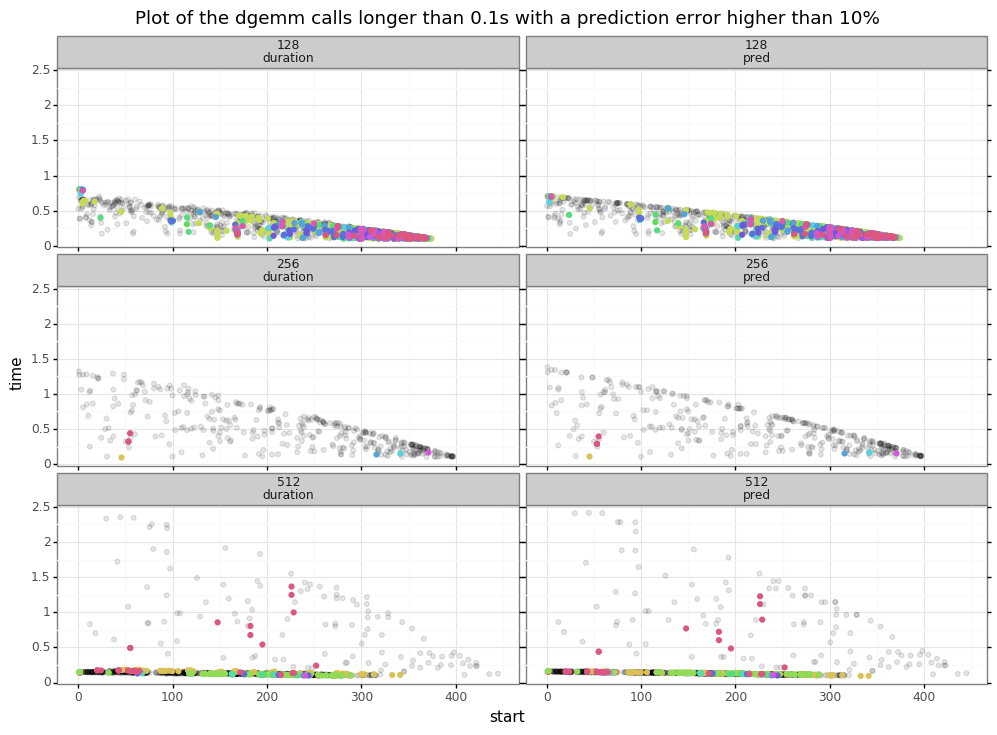

<ggplot: (-9223363276481925404)>


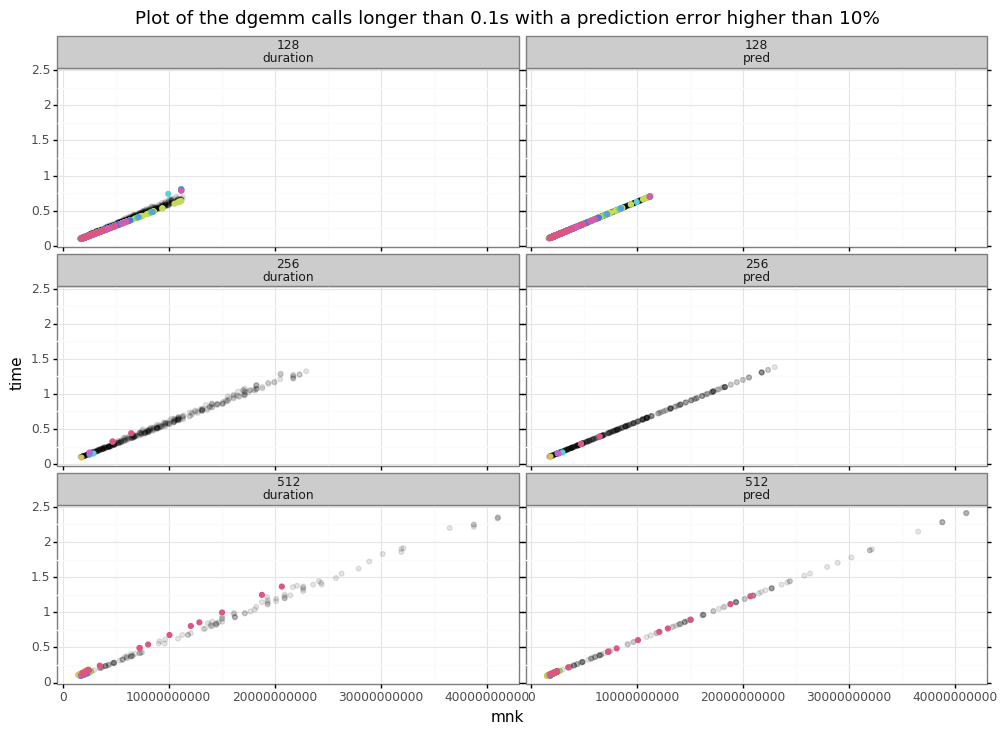

<ggplot: (-9223363276486269913)>


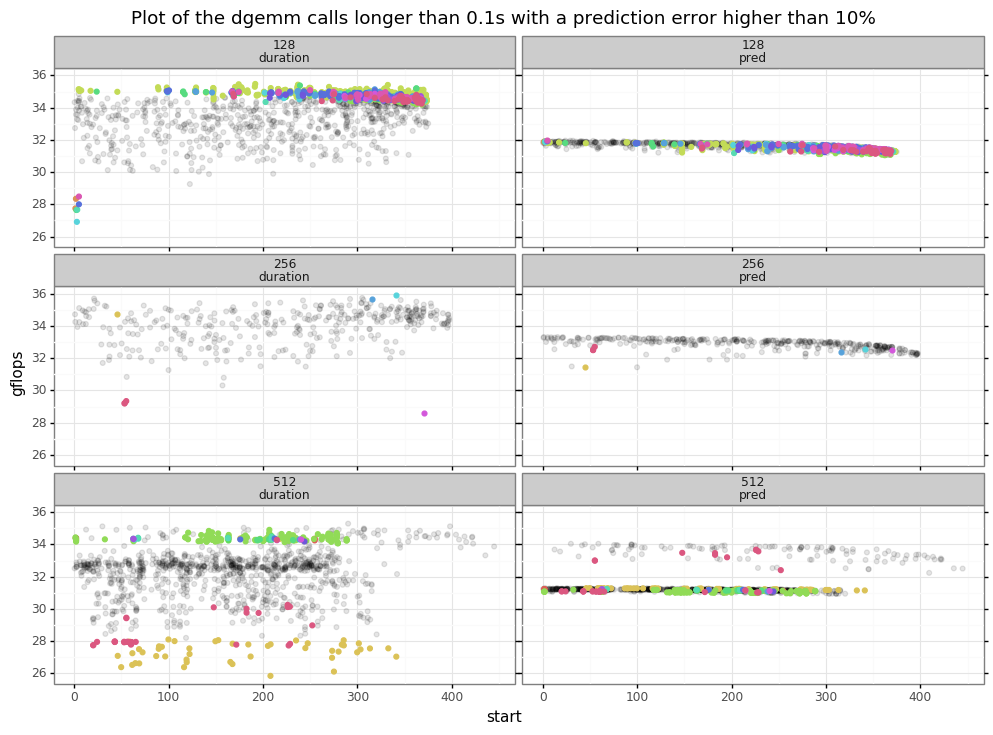

<ggplot: (8760366603994)>


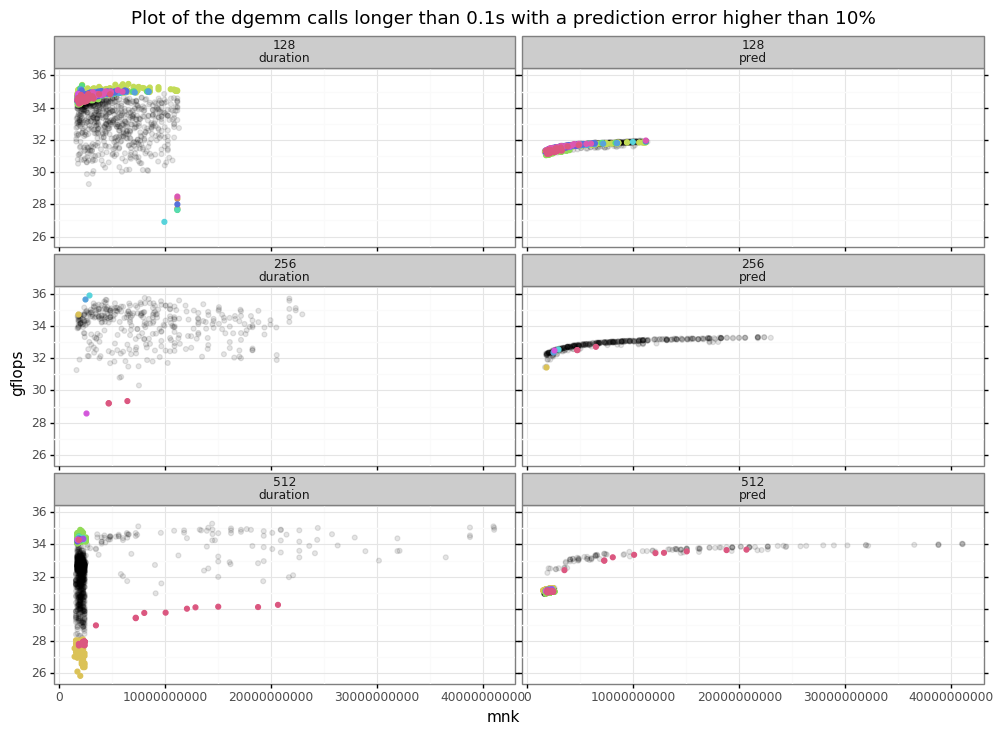

<ggplot: (-9223363276488445033)>


In [12]:
p = ggplot(melted, aes(color='factor(hostname)')) + theme_bw() + facet_wrap(['block_size', 'kind'], ncol=2)
p = p + theme(legend_position='none') + ggtitle('Plot of the dgemm calls longer than 0.1s with a prediction error higher than 10%')
for y in ['time', 'gflops']:
    for x in ['start', 'mnk']:
        print(p + geom_point(melted_nonerror, aes(x=x, y=y), color='black', alpha=0.1) + geom_point(aes(x=x, y=y)))

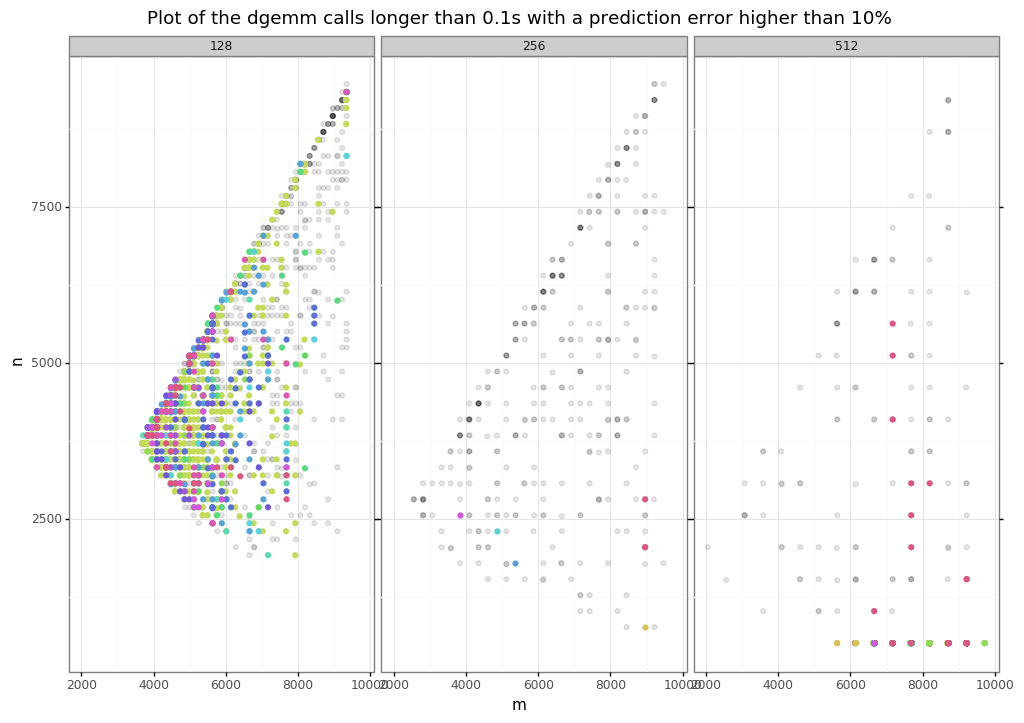

<ggplot: (8760365976731)>


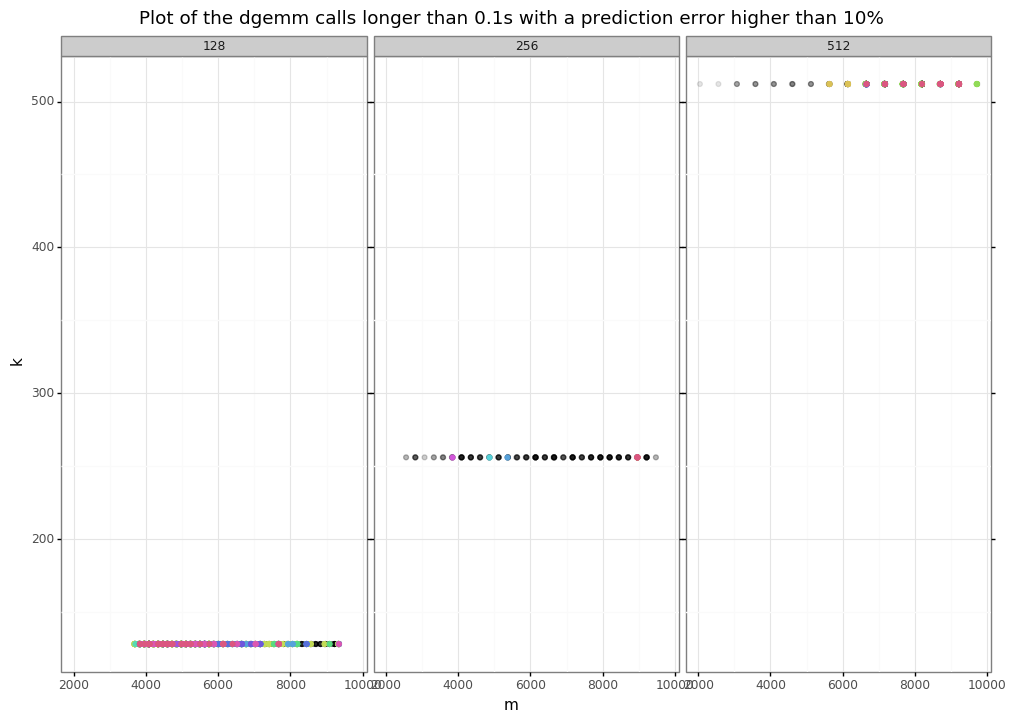

<ggplot: (-9223363276488112089)>


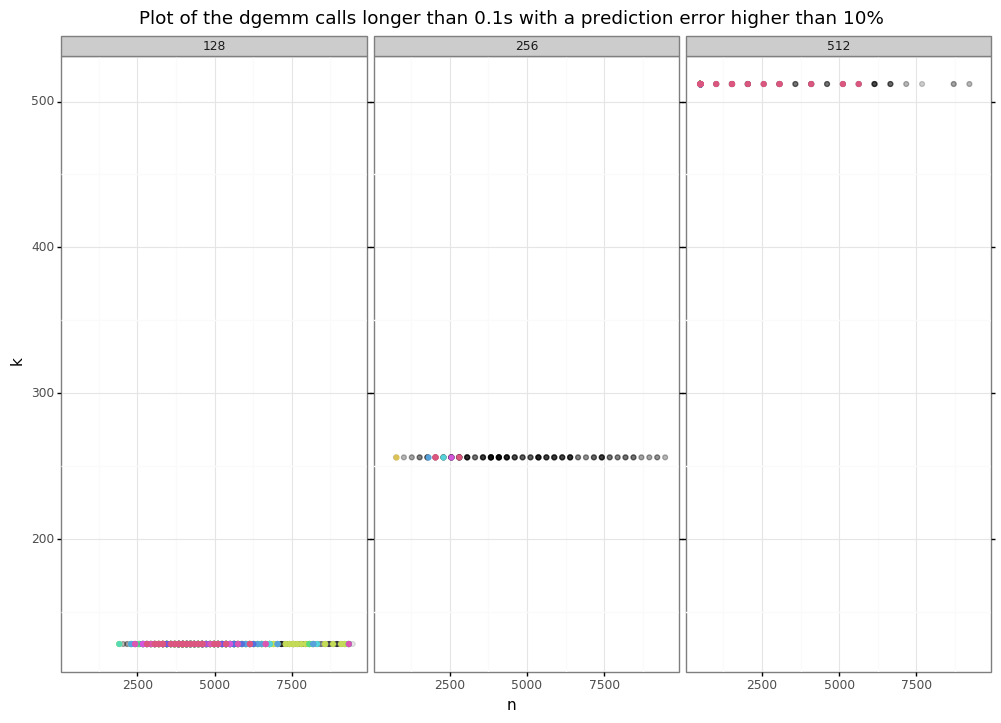

<ggplot: (8760366314458)>


In [13]:
p = ggplot(tmp, aes(color='factor(hostname)')) + theme_bw() + facet_wrap(['block_size'], ncol=3)
p = p + theme(legend_position='none') + ggtitle('Plot of the dgemm calls longer than 0.1s with a prediction error higher than 10%')
for x, y in ['mn', 'mk', 'nk']:
    print(p + geom_point(tmp_nonerror, aes(x=x, y=y), color='black', alpha=0.1) + geom_point(aes(x=x, y=y)))

In [14]:
summary = traces.groupby(['block_size', 'hostname', 'node', 'socket', 'cpu', 'rank'])[['duration', 'pred', 'mnk']].sum().reset_index()
summary['gflops_real'] = 2*summary['mnk'] / summary['duration'] * 1e-9
summary['gflops_pred'] = 2*summary['mnk'] / summary['pred'] * 1e-9
summary['error'] = (summary['pred'] - summary['duration']) / summary['duration']
summary['abs_error'] = summary['error'].abs()
summary.sort_values(by='abs_error', ascending=False).head(n=10)

,block_size,hostname,node,socket,cpu,rank,duration,pred,mnk,gflops_real,gflops_pred,error,abs_error
168,128,paravance-27.rennes.grid5000.fr,27,1,53,168,268.568291,304.977231,4.365300e+12,32.507935,28.627057,0.135567,0.135567
99,128,paravance-23.rennes.grid5000.fr,23,0,44,99,275.855202,308.314122,4.393591e+12,31.854330,28.500746,0.117667,0.117667
97,128,paravance-23.rennes.grid5000.fr,23,0,44,97,270.261826,301.233524,4.392704e+12,32.507024,29.164774,0.114599,0.114599
226,128,paravance-31.rennes.grid5000.fr,31,0,60,226,275.915308,306.552766,4.443683e+12,32.210489,28.991312,0.111039,0.111039
171,128,paravance-27.rennes.grid5000.fr,27,1,53,171,267.425562,296.331830,4.382065e+12,32.772223,29.575393,0.108091,0.108091
152,128,paravance-26.rennes.grid5000.fr,26,1,51,152,274.975369,304.434630,4.359789e+12,31.710397,28.641873,0.107134,0.107134
100,128,paravance-23.rennes.grid5000.fr,23,0,44,100,275.852705,305.344101,4.320597e+12,31.325395,28.299858,0.106910,0.106910
170,128,paravance-27.rennes.grid5000.fr,27,1,53,170,270.019364,298.831623,4.376591e+12,32.416871,29.291354,0.106704,0.106704
120,128,paravance-24.rennes.grid5000.fr,24,1,47,120,274.598537,303.751117,4.348538e+12,31.671967,28.632243,0.106164,0.106164
169,128,paravance-27.rennes.grid5000.fr,27,1,53,169,272.071261,300.944215,4.370965e+12,32.131029,29.048339,0.106123,0.106123


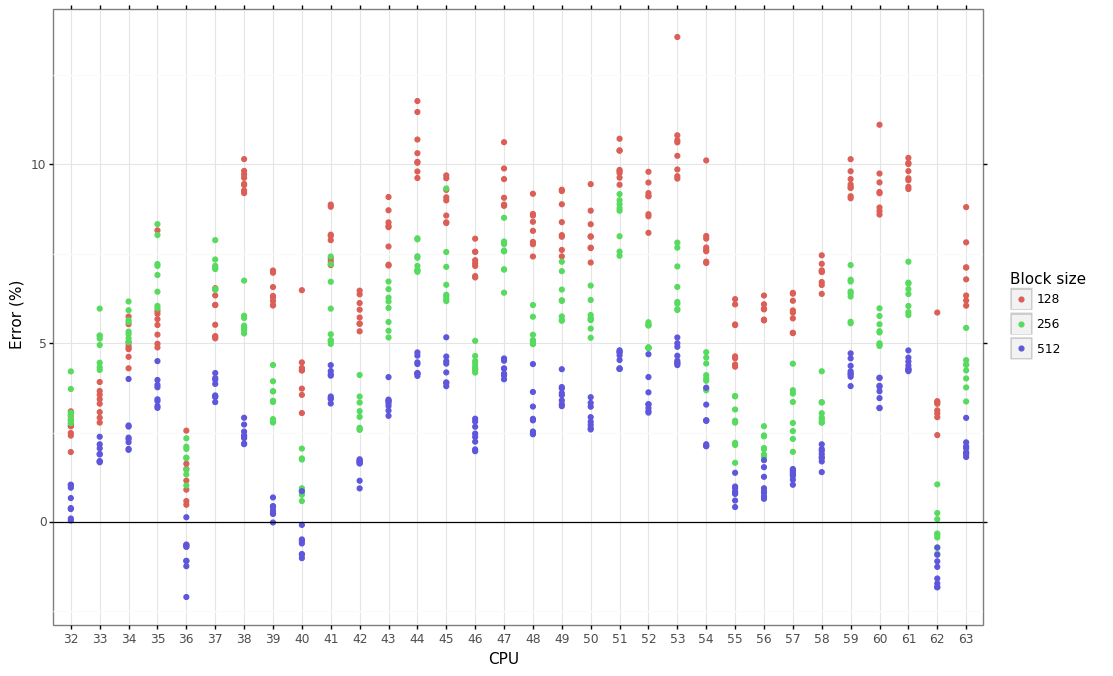

<ggplot: (8760366684971)>

In [15]:
tmp = summary.copy()
tmp['error'] *= 100
plot = ggplot(tmp, aes(x='factor(cpu)', y='error', color='factor(block_size)')) + geom_point() + theme_bw()
plot = plot + geom_hline(yintercept=0) + ylab('Error (%)') + xlab('CPU') + labs(color='Block size')
plot

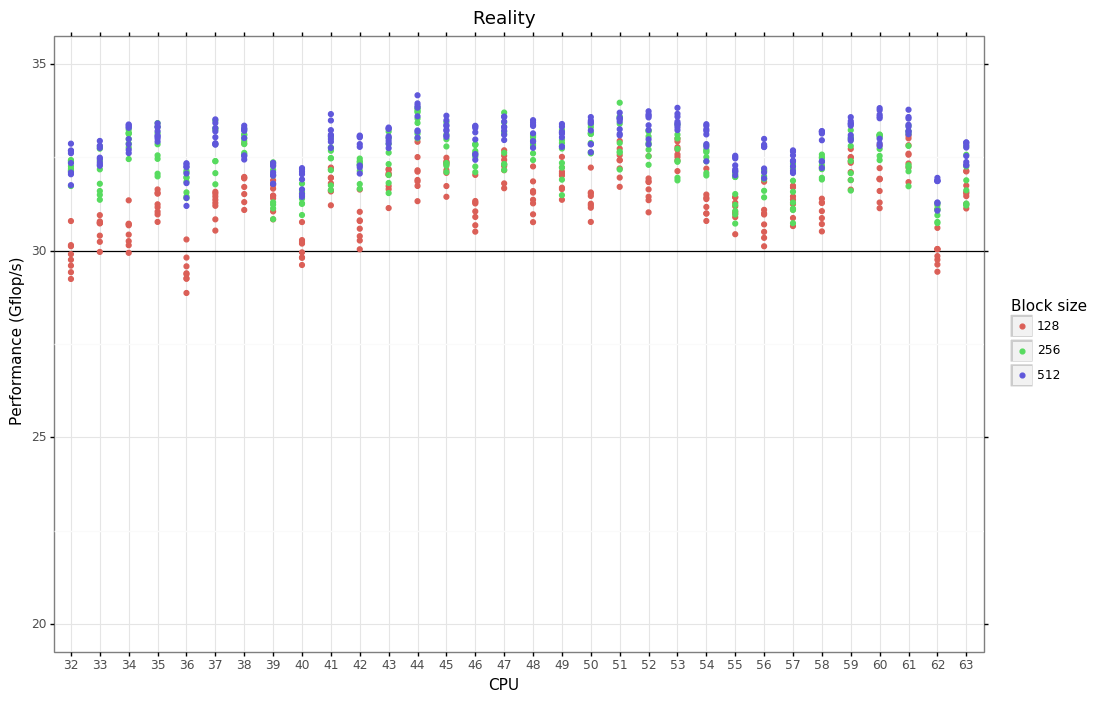

<ggplot: (8760366791474)>


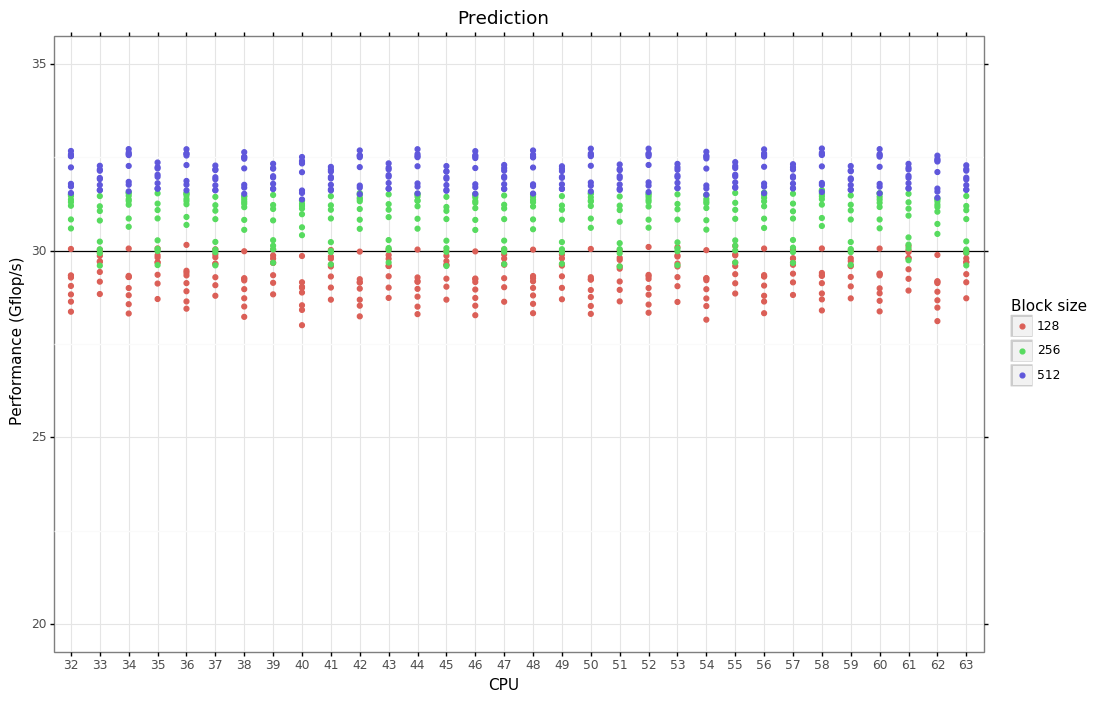

<ggplot: (-9223363276449731966)>


In [16]:
plot = ggplot(tmp, aes(x='factor(cpu)', color='factor(block_size)')) + theme_bw()
plot = plot + geom_hline(yintercept=30) + ylab('Performance (Gflop/s)') + xlab('CPU') + labs(color='Block size') + expand_limits(y=20) + expand_limits(y=35)
print(plot + geom_point(aes(y='gflops_real')) + ggtitle('Reality'))
print(plot + geom_point(aes(y='gflops_pred')) + ggtitle('Prediction'))

In [17]:
dump = traces[(traces['rank'] == 0) & (traces['block_size'] == 512)].sort_values(by='start', axis=0)[['function', 'm', 'n', 'k']]
dump.m = dump.m.astype('int')
dump.n = dump.n.astype('int')
dump.k = dump.k.astype('int')
dump.to_csv('/tmp/exp_hpl.csv', index=False, header=False)